# Synthetic Data Generation

### Synthetic data from real data

합성 데이터 생성은 데이터 요구 사항 증가와 데이터에 대한 프라이버시 문제 등으로 인해 주목받고 있는 분야이다. 은닉 마르코프 모델(HMM)은 합성 데이터를 생성하는 대표적인 모델 중 하나이다. 

합성 데이터는 실제 데이터의 통계적 특성을 모방하는 과정에서 생성된 데이터이다. 데이터는 원 데이터로부터 모델링되어야 한다는 믿음이 있지만, 반드시 실제 데이터에서 합성 데이터를 생성하는 것 만이 유일한 방법은 아니다. 합성 데이터를 생성하는 방법에는 세 가지 방법이 알려져 있다.

1. 실제 데이터를 이용해 합성 데이터를 생성하는 방법. 이 프로세스는 실제 데이터를 가져오는 것에서 시작해 데이터 분포를 모델링하고 마지막으로 해당 분포 모델로부터 합성 데이터를 샘플링한다.

2. 합성 데이터는 모델 또는 지식으로부터 얻을 수 있다. 일반적으로 이러한 유형의 합성 데이터 생성은 기존 모델을 사용하거나 연구자의 지식을 바탕으로 생성된다.

3. 하이브리드 프로세스는 앞의 두 단계를 모두 포함한다. 이런 하이브리드 프로세스는 데이터의 일부만 사용 가능할 때 많이 적용되며, 실제 데이터로 합성 데이터를 일부 생성한 뒤 나머지 부분을 모델로부터 얻어온다.

그렇다면 합성 데이터의 품질은 어떻게 평가할 수 있을까? 일반적으로는 KL-분산, 구별 가능성(Distinguishable), ROC 곡선, 평균&중앙값 4가지 방법론이 사용된다. 

구별 가능성(Distinguishable)은 분류 모델이 실제 데이터와 합성 데이터를 구분하는 경우 실제 데이터에 1을 할당한다. 만일 실제 데이터와 합성 데이터를 구분하지 못한다면 0을 할당한다. 출력이 1에 가까우면 데이터는 실제라고 예측하고, 그렇지 않으면 성향 점수(Propensity score)를 사용해 합성 데이터라고 예측한다.

혹은 실제 데이터와 합성 데이터의 평균과 분산과 같이 주요 통계량을 이용해 합성 데이터가 실제 데이터를 잘 모방하는지 파악할 수 있다.

다음은 실제 데이터를 이용해 합성 데이터를 만들어 내는 코드이다.

In [97]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [98]:
X, y = fetch_california_housing(return_X_y=True)

In [99]:
california_housing=np.column_stack([X, y])
california_housing_df=pd.DataFrame(california_housing)
california_housing_df=california_housing_df.sample(1000)

In [100]:
california_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 18964 to 14700
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
dtypes: float64(9)
memory usage: 78.1 KB


여기서는 생성적 적대 네트워크를 이용해 합성 데이터를 만들어내는 방법에 대해 다룬다.

### 생성적 적대 네트워크(GAN)

생성적 적대 네트워크(이하 GAN)는 두가지 모델로 이뤄져 있다. 하나는 데이터를 합성하는 모델이며, 하나는 입력받은 데이터가 합성된 데이터인지, 아니면 실제 데이터인지 판별하는 모델이다. GAN은 데이터를 합성한 뒤 (혹은 그냥 진짜 데이터를) 판별 모델이 받아 실제인지 합성인지 판별하고 이를 다시 합성 모델에 전달하는 식으로 훈련이 진행된다. 현금 위조범과 위조 판별사를 생각해보자. 현금 위조범의 첫 결과물은 너무 조잡하여 위조 판별사는 간단하게 실제 현금과 위조 현금을 구분할 수 있을 것이다. 하지만 이 결과를 위조범이 계속 받게 되어 시간이 지날수록 더욱 정교한 위조 현금이 생성될 것이다. 결과적으로, 위조 판별사는 실제 현금과 위조 현금을 분별하지 못할 것이다.

<center>
    
<img src="./Image/GAN.png" width="700px" height="400px">
    
</center>

이를 수식적으로 서술하면 다음과 같다.

$$ \min_G \max_D V(D, G) = E_{x\sim p_{data}(x)}[logD(x)] + E_{z\sim p_{z}(z)}[log(1-D(G(z)))]$$

여기서 G는 생성 모델을 의미하며, D는 판별 모델을 의미한다. 생성 모델은 데이터 x로부터 생성 분포 $p_g$를 학습하고자 한다. 따라서 생성 모델은 사전 잡음 분포 $p_z(z)$로부터 데이터 스페이스 $G(z;\theta_g)$ 로 매핑하는 함수를 만든다. 여기서 Z는 Latent vector라고도 하며 데이터의 분포를 잘 설명하는 잠재 공간에서의 벡터를 의미한다. 판별 모델 $D(x;\theta_d)$는 x가 생성 분포 $p_g$가 아닌 데이터 x에서 올 확률을 계산한다. 앞쪽 파트 $E_{x\sim p_{data}(x)}[logD(x)]$는 판별 모델로 온 데이터가 실제 데이터에서 왔을 것으로 판단되는 기대값을 의미하며, $E_{z\sim p_{z}(z)}[log(1-D(G(z)))]$는 데이터가 생성 모델로부터 온 것으로 판단하는 기대값을 의미한다. 

분류모델은 해당 손실함수를 최대화해야 하고 생성모델은 손실함수를 최소화 해야 한다. 그러기 위해서는 분류 모델의 입장에서는 $D(x)=1, \ D(G(z))=0$이 되어야 한다. 즉 생성모델이 만들어 낸 데이터는 가짜로 분류해야 하고, 진짜 데이터는 진짜로 판별해야 한다. 생성 모델의 입장에서는 $D(G(z))=\frac{1}{2}$로 만들어야 한다. 즉, 분류모델이 진짜인지 가짜인지 아예 구분하지 못하는 데이터를 만들어야 한다.

### 조건부 GAN(Conditional Generative Adversarial Nets)

조건부 GAN(이하 CGAN)은 GAN과 비슷하나 약간의 차이점을 가진다. 생성 모델과 판별 모델이 새로운 정보 y에 근거하여 만들어져야 한다는 것이다. 여기서 y는 class label, 다른 양식의 데이터 등 어떠한 보조적 데이터든 될 수 있다. 이 사전 정보는 추가적인 input layer로 생성 모델과 판별 모델 모두에게 주어진다.

수식적으로 설명하면 다음과 같다. 생성모델의 사전 input noize(혹은 Latent vector) $p_z(z)$와 y는 joint hidden representation으로 결합된다. 그리고 적대적 훈련 기법은 joint hidden representation을 구현하는 과정에 충분한 유동성을 제공한다.

CGAN의 목적함수는 다음과 같이 변경된다.

$$ \min_G \max_D V(D, G) = E_{x\sim p_{data}(x)}[logD(x\vert y)] + E_{z\sim p_{z}(z)}[log(1-D(G(z\vert y)))]$$

<center>
    
<img src="./Image/CGAN.png" width="700px" height="500px">
    
</center>

`ctgan` 라이브러리는 조건부 생성적 적대 네트워크(CGAN)모델을 이용해 원본 데이터에 대한 충실도가 높은 합성 데이터를 생성해낸다.

In [101]:
columns=[str(i) for i in range(9)]
california_housing_df.columns=columns

In [102]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=10)
ctgan.fit(california_housing_df, california_housing_df.columns)
synt_sample = ctgan.sample(len(california_housing_df))

In [103]:
california_housing_df.describe()

0            1            2            3             4  \
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.000000   
mean      3.849430    29.223000     5.472573     1.107779   1409.158000   
std       1.927926    12.497979     2.743506     0.577944   1106.815668   
min       0.706800     2.000000     1.629630     0.700000     14.000000   
25%       2.543800    19.000000     4.405406     1.004416    804.750000   
50%       3.520650    29.000000     5.191808     1.047479   1159.000000   
75%       4.683400    38.000000     6.055118     1.094797   1694.500000   
max      15.000100    52.000000    59.875000    15.312500  16305.000000   

                 5            6            7            8  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      2.985168    35.600770  -119.546060     2.046498  
std       1.771355     2.105222     1.976323     1.167983  
min       1.301961    32.550000  -124.210000     0.149990  
25%       2.442772    33.957500  -121.655000     1.161250  
50%       2.829197    34.255000  -118.555000     1.731500  
75%       3.269331    37.672500  -118.030000     2.608250  
max      51.400000    41.950000  -114.650000     5.000010

In [104]:
synt_sample.describe()

0            1            2            3             4  \
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.000000   
mean      3.834235    27.429000     5.517688     1.112547   1510.098000   
std       1.809476    13.970904     3.203765     0.616288   1371.797064   
min       0.760000     2.000000     1.629630     0.754386     27.000000   
25%       2.574675    16.000000     4.395730     1.003183    807.000000   
50%       3.480000    27.000000     5.197976     1.042582   1214.500000   
75%       4.680150    39.000000     6.038011     1.089963   1773.000000   
max      15.000100    52.000000    59.875000    15.312500  16305.000000   

                 5            6            7            8  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      2.946570    35.921980  -119.716000     1.907441  
std       1.694961     2.267411     2.030384     1.000544  
min       1.365385    32.550000  -124.210000     0.149990  
25%       2.415090    33.930000  -121.580000     1.136750  
50%       2.817166    35.640000  -119.580000     1.695000  
75%       3.246985    37.780000  -118.055000     2.462500  
max      51.400000    41.950000  -114.650000     5.000010

In [105]:
from sdv.evaluation import single_table
from sdv.metadata import Metadata
from sdv.evaluation.single_table import get_column_plot

metadata=Metadata.detect_from_dataframe(data=california_housing_df, table_name='california')
for column in columns:
    metadata.update_column(column_name=column, sdtype='numerical')


In [106]:
single_table.evaluate_quality(california_housing_df, synt_sample, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 772.95it/s]|
Column Shapes Score: 93.8%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 384.62it/s]|
Column Pair Trends Score: 92.43%

Overall Score (Average): 93.11%



In [107]:
for column in california_housing_df.columns:

    fig = get_column_plot(
        real_data=california_housing_df,
        synthetic_data=synt_sample,
        metadata=metadata,
        column_name=column
    )
        
    fig.show()

### Synthetic data from model

In [108]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from matplotlib import cm

In [109]:
X, y = make_regression(n_samples=1000, n_features=3, noise=0.2,
                       random_state=123)

plt.scatter(X[:, 0], X[:, 1], alpha= 0.3, cmap='Greys', c=y)

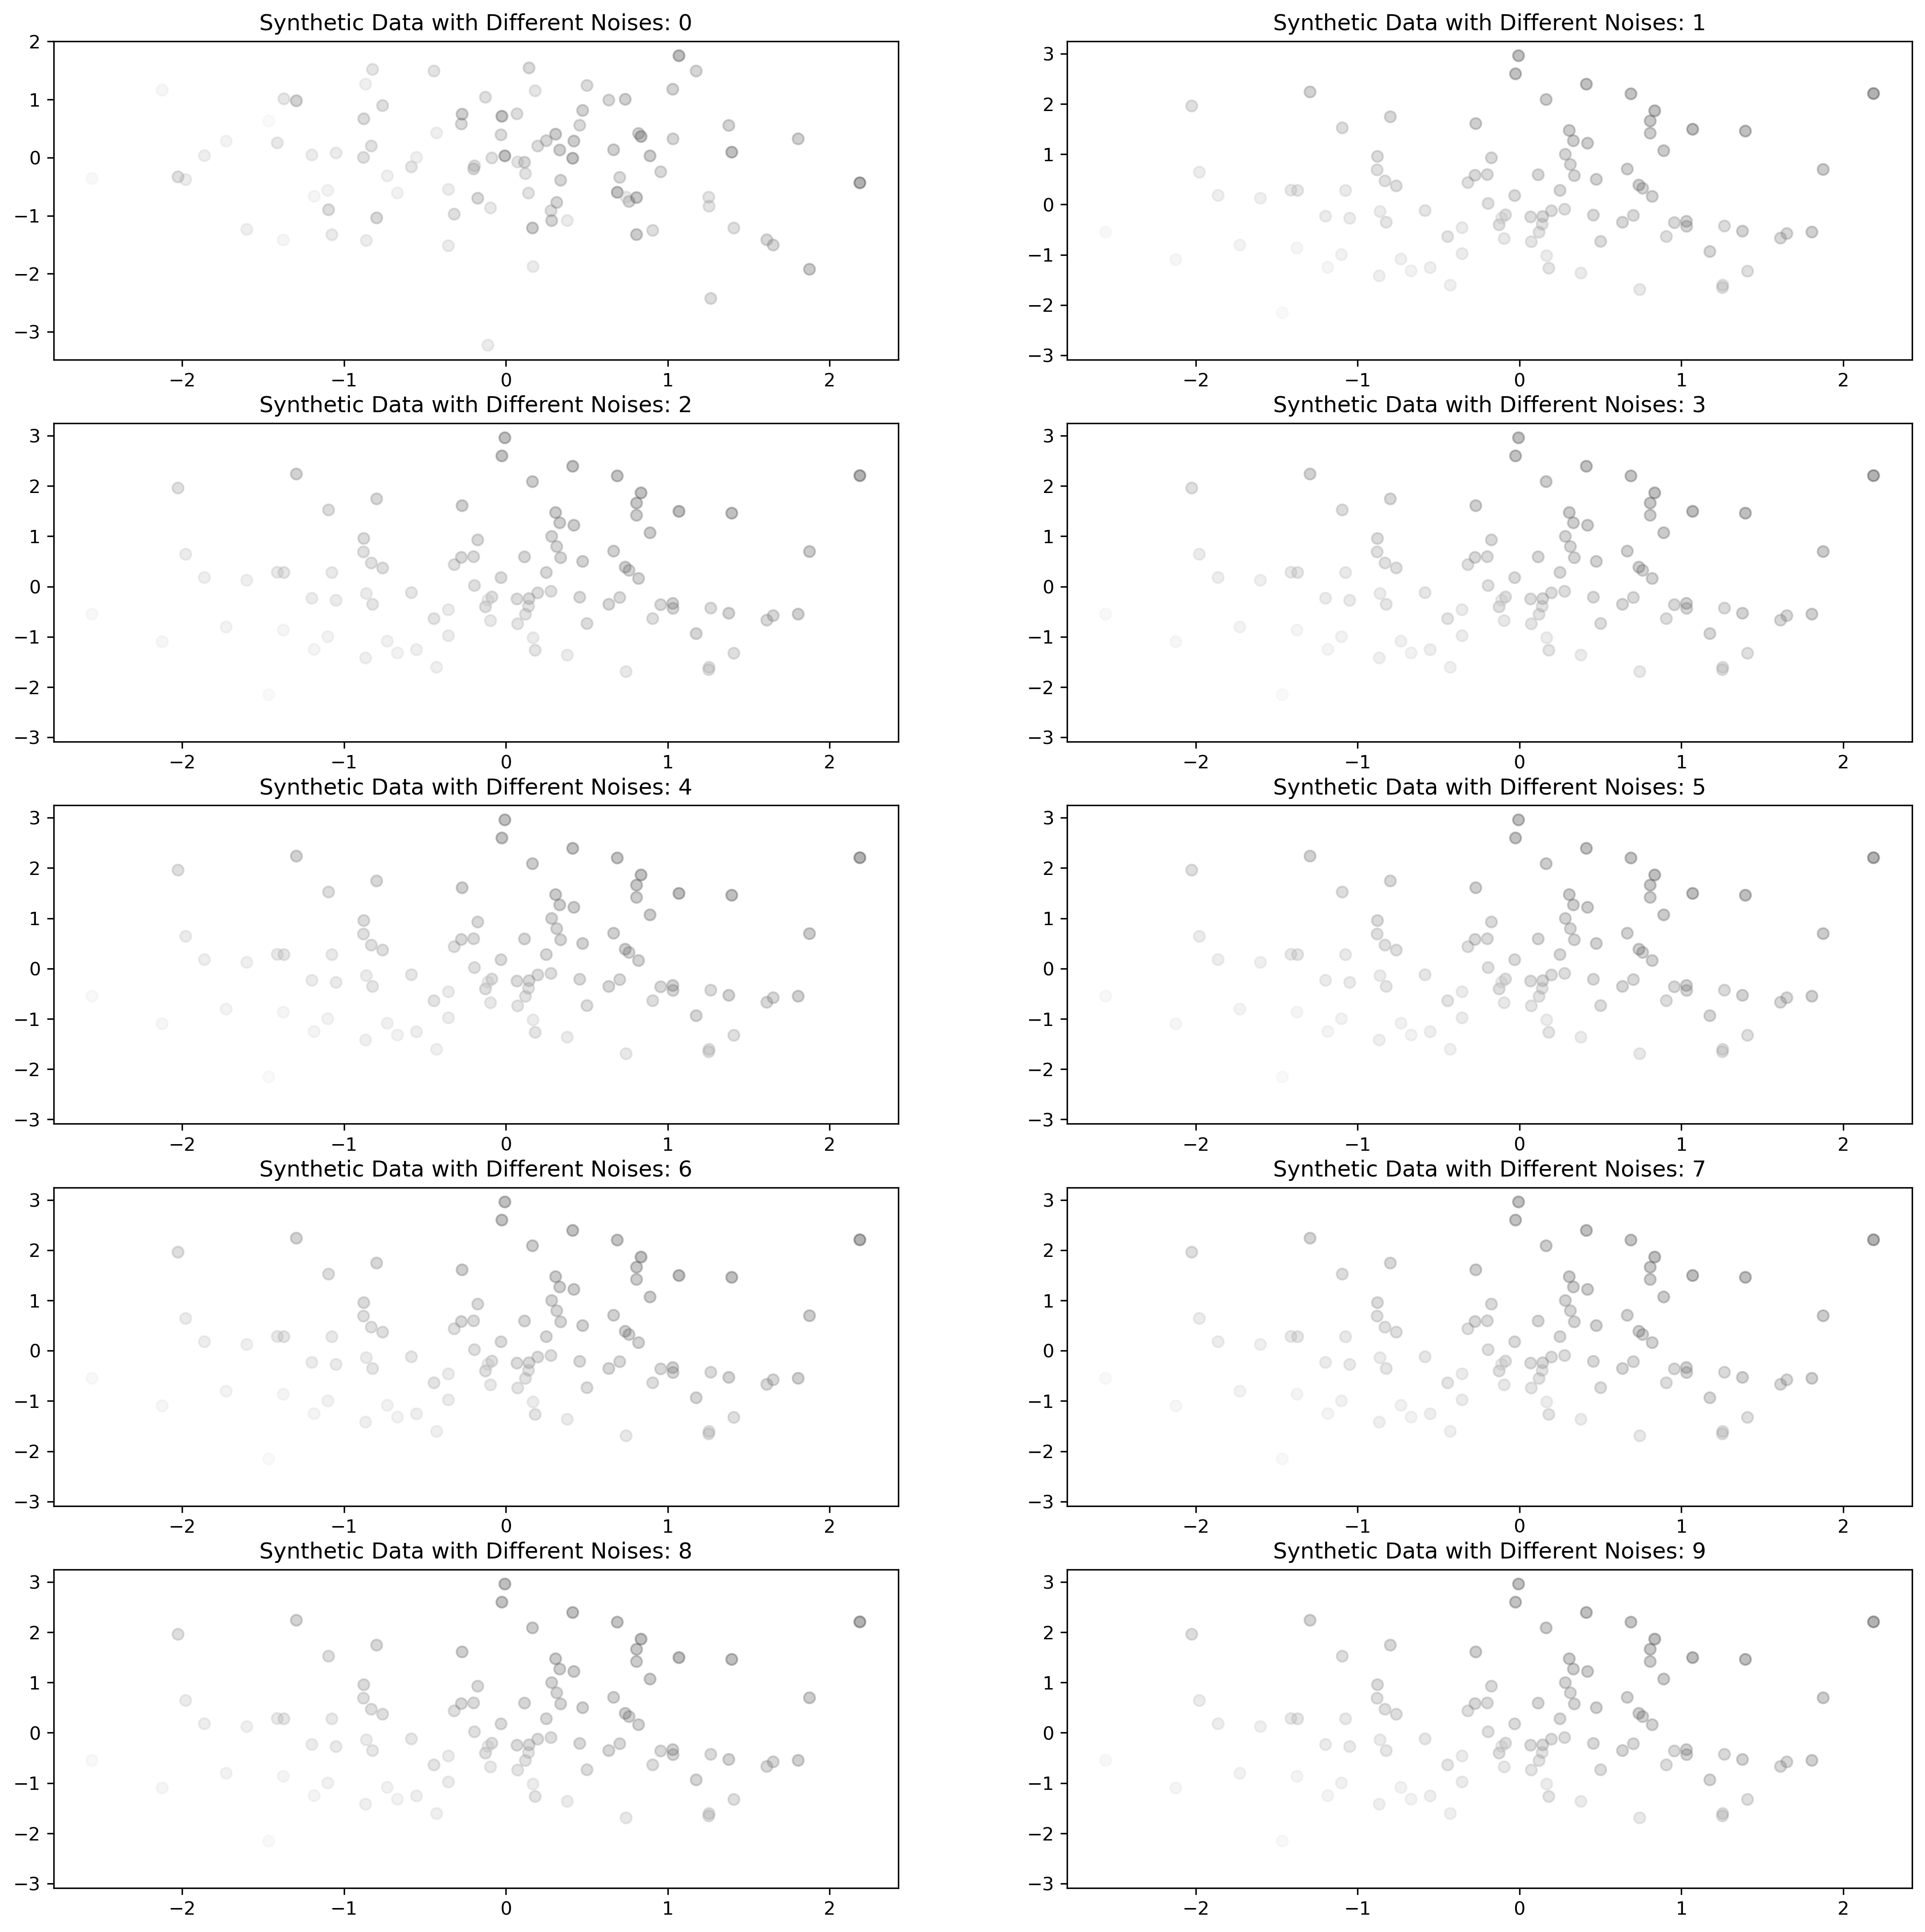

In [110]:
plt.figure(figsize=(18, 18))
k = 0

for i in range(0, 10):
    X, y = make_regression(n_samples=100, n_features=3, noise=i,
                           random_state=123) 
    k+=1
    plt.subplot(5, 2, k)
    profit_margin_orange = np.asarray([20, 35, 40])
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, cmap=cm.Greys, c=y)
    plt.title('Synthetic Data with Different Noises: ' + str(i))
plt.show()

In [111]:
from sklearn.datasets import make_classification

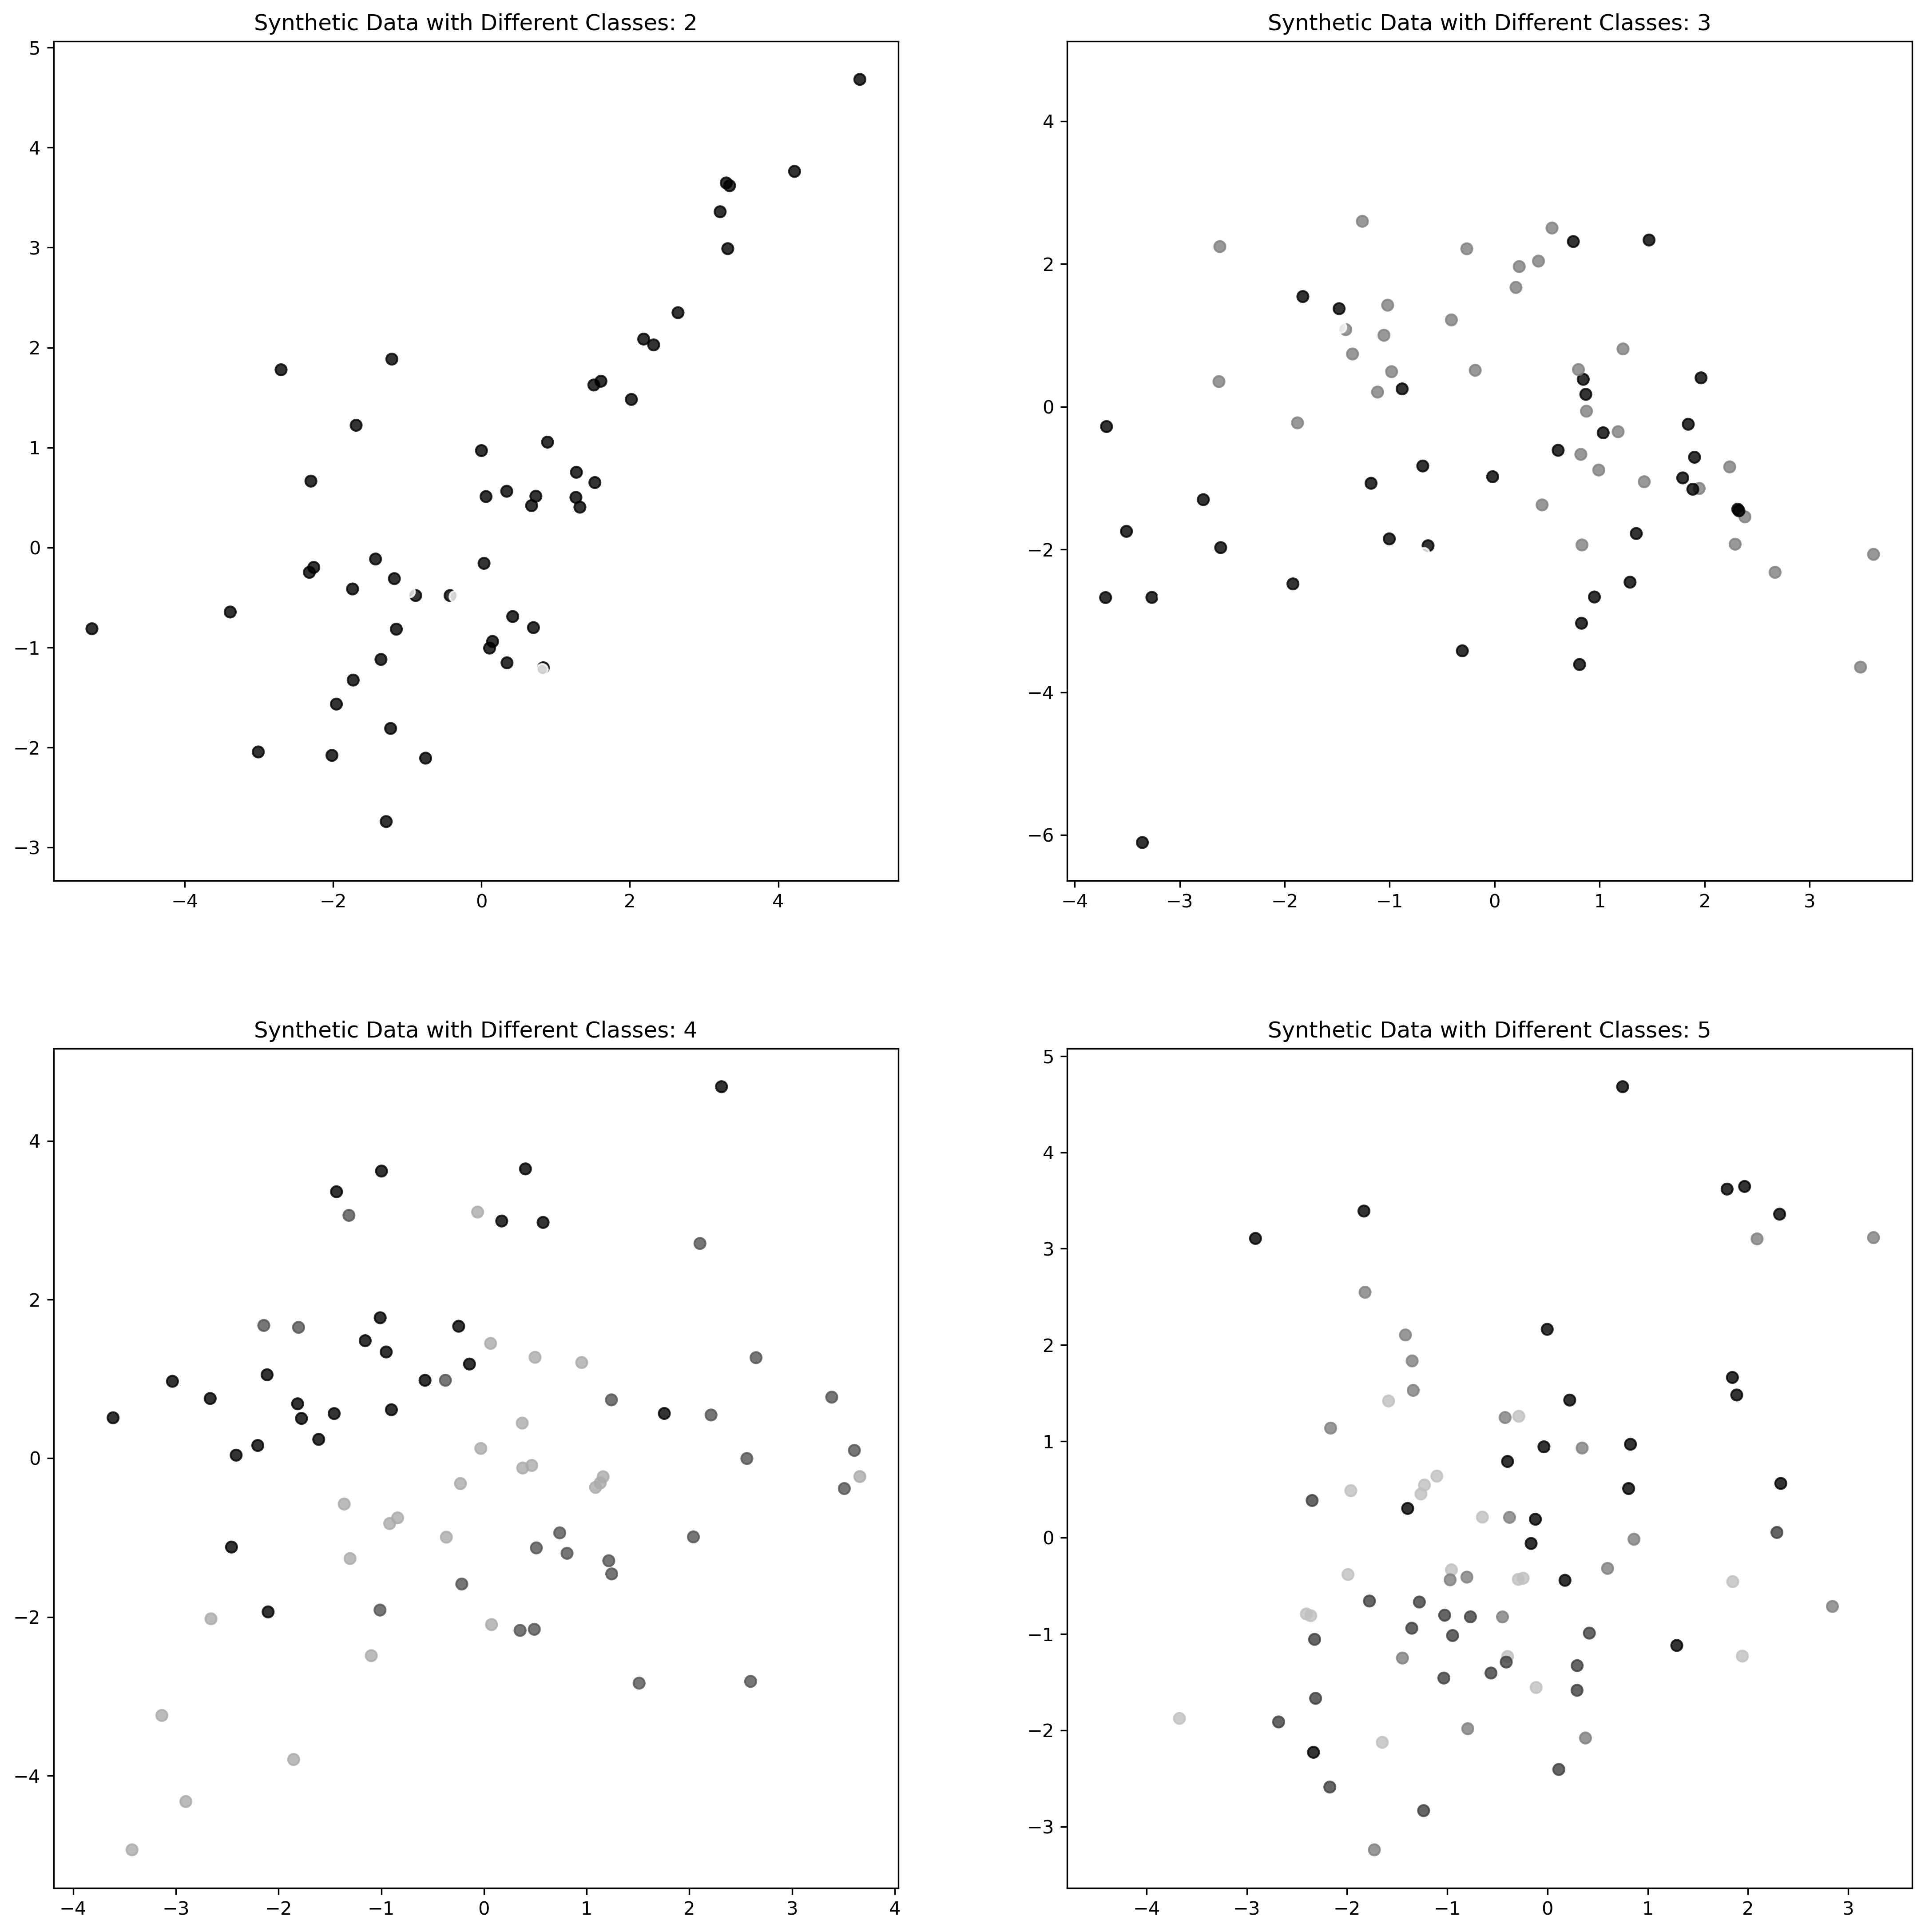

In [112]:
plt.figure(figsize=(18, 18))
k = 0

for i in range(2, 6):
    X, y = make_classification(n_samples=100,
                               n_features=4,
                               n_classes=i,
                               n_redundant=0,
                               n_informative=4,
                               random_state=123)
    k+=1
    plt.subplot(2, 2, k)
    plt.scatter(X[: ,0], X[:, 1], alpha=0.8, cmap='gray', c=y)
    plt.title('Synthetic Data with Different Classes: ' + str(i))
plt.show()

## Synthetic Data for Unsupervised Learning

In [113]:
from sklearn.datasets import make_blobs

In [114]:
X, y = make_blobs(n_samples=100, centers=2, 
                      n_features=2, random_state=0)

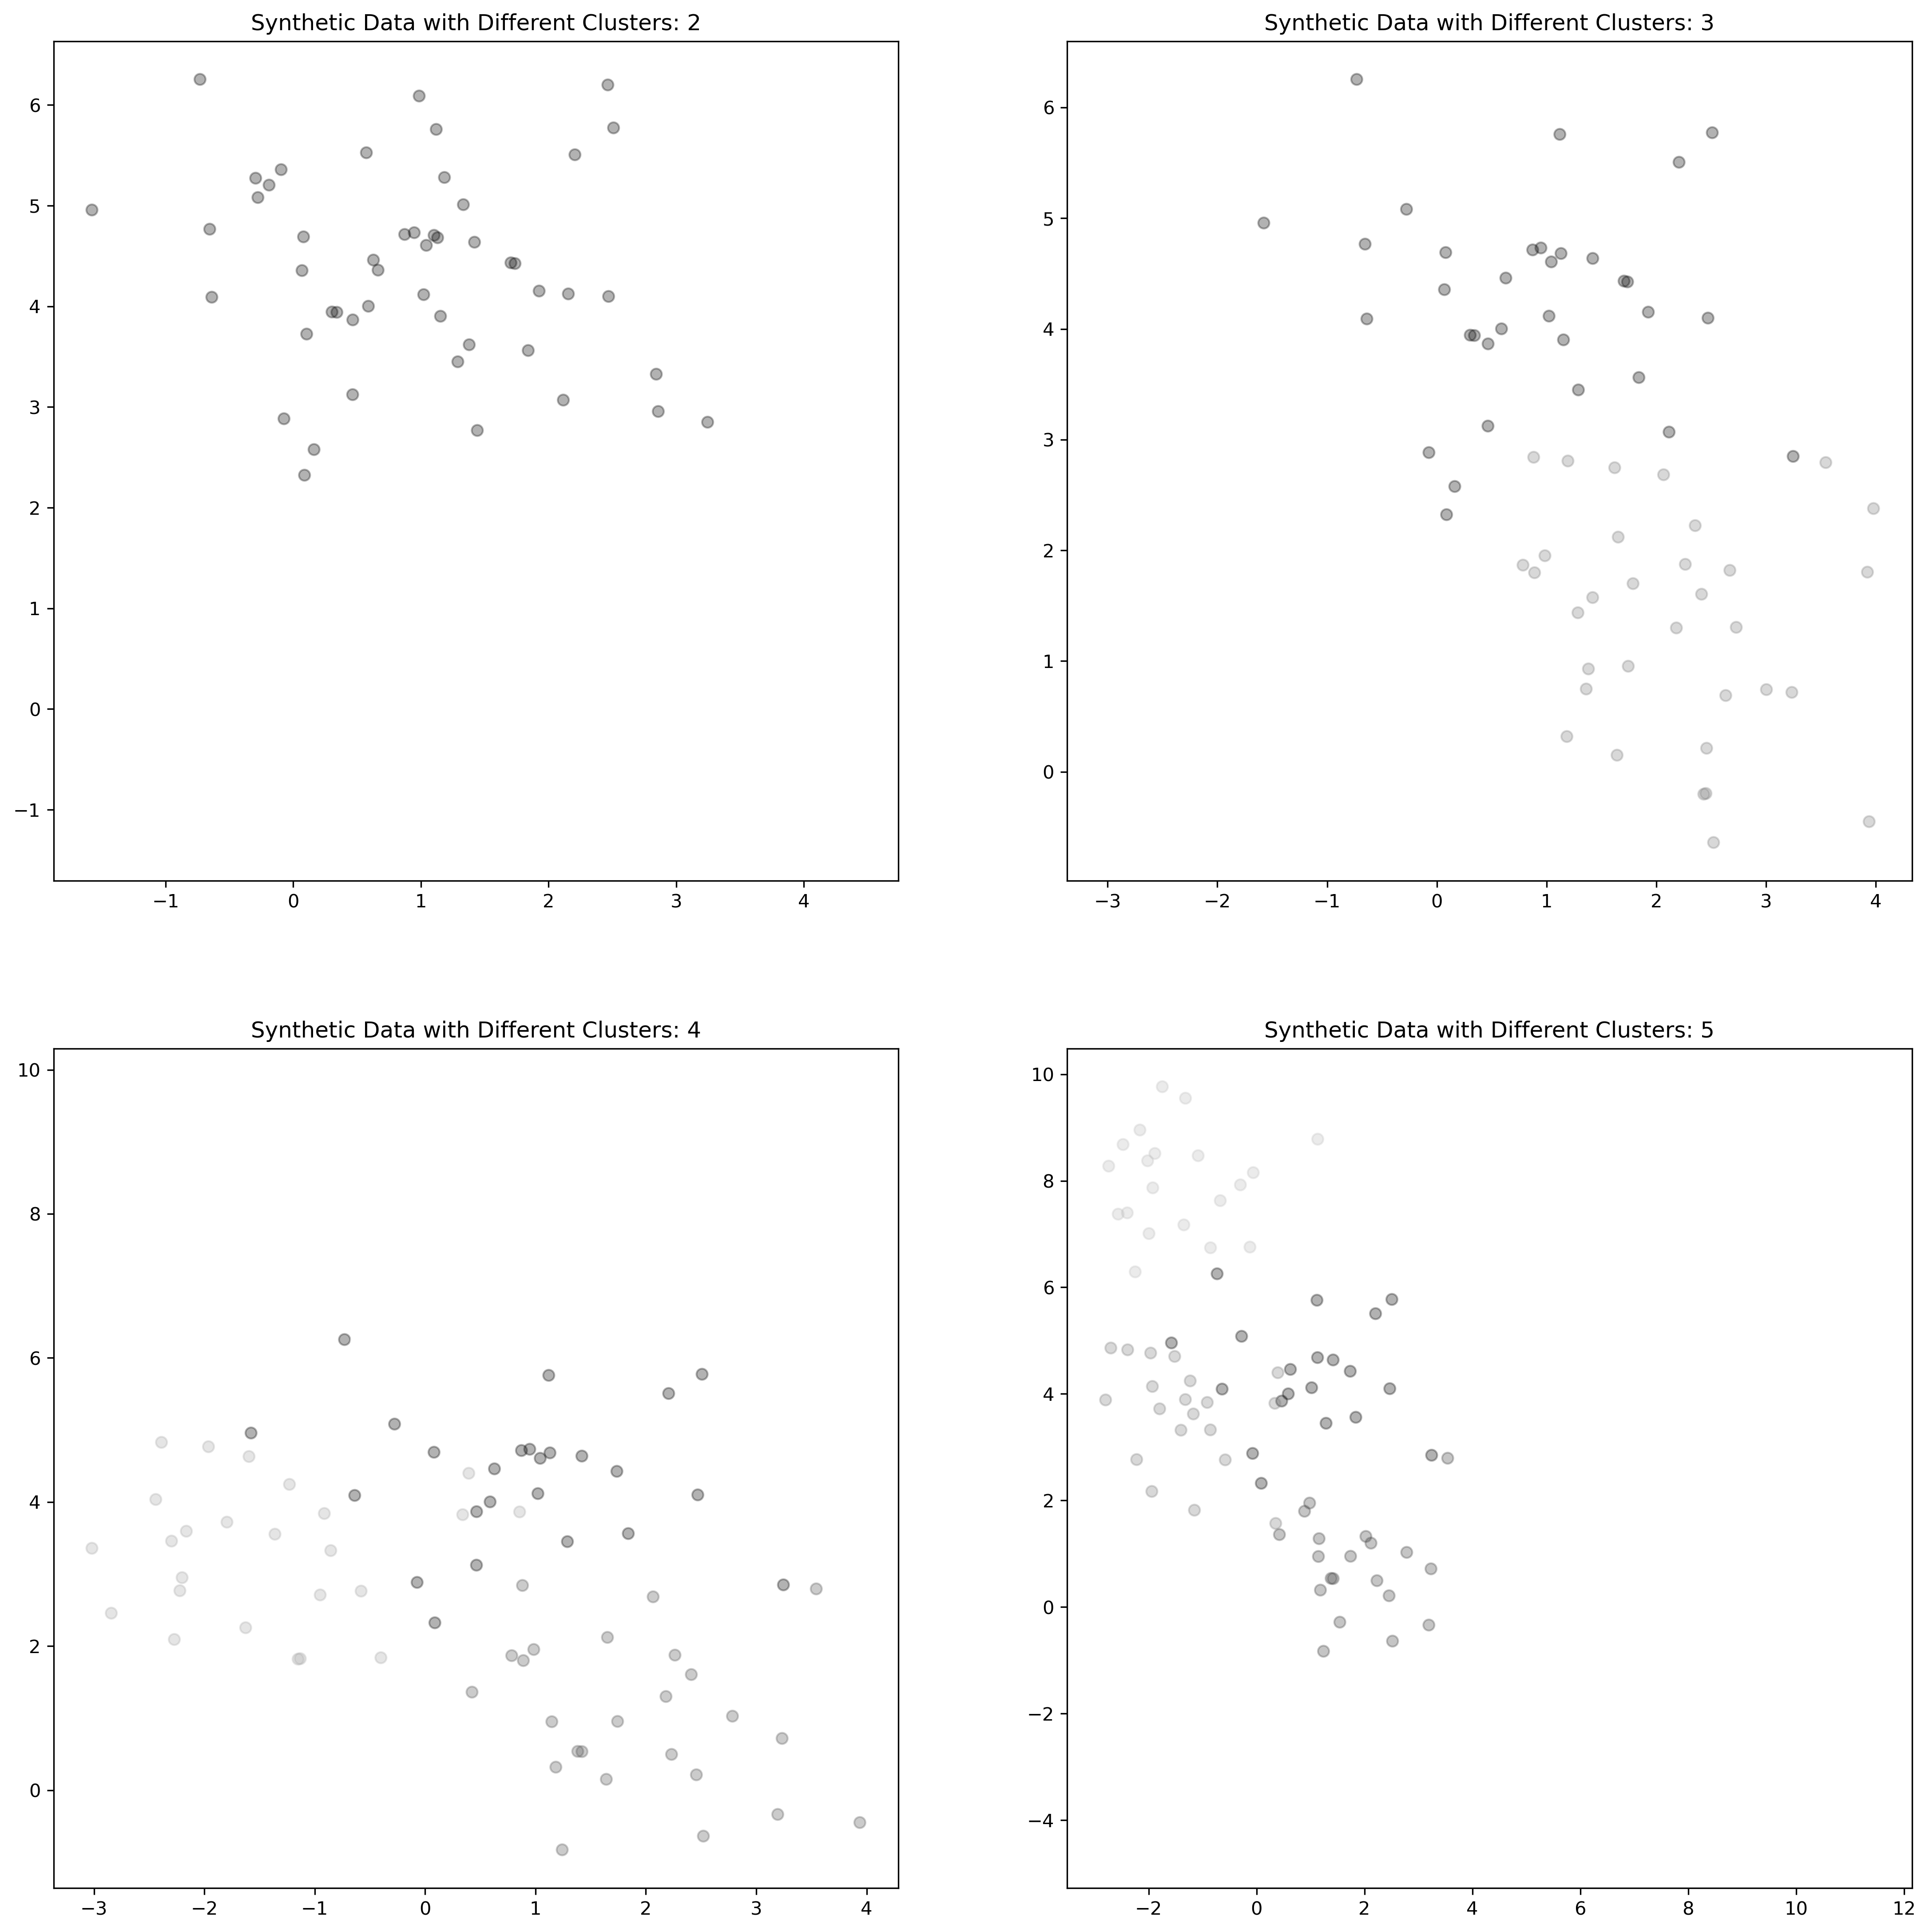

In [115]:
plt.figure(figsize=(18, 18))
k = 0
for i in range(2, 6):
    X, y = make_blobs(n_samples=100, centers=i,
                      n_features=2, random_state=0)
    k += 1
    plt.subplot(2, 2, k)
    my_scatter_plot = plt.scatter(X[:, 0], X[:, 1],
                                  alpha=0.3, cmap='gray', c=y)
    plt.title('Synthetic Data with Different Clusters: ' + str(i))
plt.show()

## HMM

In [116]:
ff = pd.read_csv('./data/FF3.csv', skiprows=4)
ff = ff.rename(columns={'Unnamed: 0': 'Date'})
ff = ff.iloc[:-1]
ff.head()

Date  Mkt-RF   SMB   HML     RF
0  19260701    0.10 -0.24 -0.28  0.009
1  19260702    0.45 -0.32 -0.08  0.009
2  19260706    0.17  0.27 -0.35  0.009
3  19260707    0.09 -0.59  0.03  0.009
4  19260708    0.21 -0.36  0.15  0.009

In [117]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24978 entries, 0 to 24977
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    24978 non-null  object 
 1   Mkt-RF  24978 non-null  float64
 2   SMB     24978 non-null  float64
 3   HML     24978 non-null  float64
 4   RF      24978 non-null  float64
dtypes: float64(4), object(1)
memory usage: 975.8+ KB


In [118]:
ff['Date'] = pd.to_datetime(ff['Date'])
ff.set_index('Date', inplace=True)
ff_trim = ff.loc['2000-01-01':]

In [119]:
ff_trim.head()

Mkt-RF   SMB   HML     RF
Date                                 
2000-01-03   -0.71  0.61 -1.40  0.021
2000-01-04   -4.06  0.01  2.06  0.021
2000-01-05   -0.09  0.18  0.19  0.021
2000-01-06   -0.73 -0.42  1.27  0.021
2000-01-07    3.21 -0.49 -1.42  0.021

In [120]:
ticker = 'SPY'
start = datetime.datetime(2000, 1, 3)
end = datetime.datetime(2021, 4, 30)
SP_ETF = yf.download(ticker, start, end, interval='1d').Close

[*********************100%%**********************]  1 of 1 completed


In [121]:
ff_merge = pd.merge(ff_trim, SP_ETF, how='inner', on='Date')

In [122]:
SP = pd.DataFrame()
SP['Close']= ff_merge['Close']

In [123]:
SP['return'] = (SP['Close'] / SP['Close'].shift(1))-1

In [124]:
from hmmlearn import hmm

In [125]:
hmm_model = hmm.GaussianHMM(n_components=3,
                            covariance_type="full",
                            n_iter=100)

In [126]:
hmm_model.fit(np.array(SP['return'].dropna()).reshape(-1, 1))
hmm_predict = hmm_model.predict(np.array(SP['return'].dropna())
                                .reshape(-1, 1))
df_hmm = pd.DataFrame(hmm_predict)

Model is not converging.  Current: 17121.99530809203 is not greater than 17122.039329182335. Delta is -0.044021090303431265


In [127]:
ret_merged = pd.concat([df_hmm,SP['return'].dropna().reset_index()],
                       axis=1)
ret_merged.drop('Date',axis=1, inplace=True)
ret_merged.rename(columns={0:'states'}, inplace=True)
ret_merged.dropna().head()

states    return
0       2 -0.039106
1       2  0.001789
2       2 -0.016071
3       2  0.058076
4       2  0.003431

In [128]:
ret_merged['states'].value_counts()

states
0    3731
2    1438
1     195
Name: count, dtype: int64

In [129]:
state_means = []
state_std = []

for i in range(3):
    state_means.append(ret_merged[ret_merged.states == i]['return']
                       .mean())
    state_std.append(ret_merged[ret_merged.states == i]['return']
                     .std())
print('State Means are: {}'.format(state_means))
print('State Standard Deviations are: {}'.format(state_std))

State Means are: [0.0011127002811420763, -0.00696776095482342, -0.0009123020322017814]
State Standard Deviations are: [0.006224970366737002, 0.01779134651354866, 0.02075042502289785]


In [130]:
print(f'HMM means\n {hmm_model.means_}')
print(f'HMM covariances\n {hmm_model.covars_}')
print(f'HMM transition matrix\n {hmm_model.transmat_}')
print(f'HMM initial probability\n {hmm_model.startprob_}')

HMM means
 [[ 0.00112236]
 [-0.00197477]
 [-0.00090986]]
HMM covariances
 [[[4.30800216e-05]]

 [[1.76228323e-04]]

 [[4.85779021e-04]]]
HMM transition matrix
 [[8.36826025e-01 1.63160635e-01 1.33401206e-05]
 [8.59203449e-01 9.07588807e-02 5.00376699e-02]
 [1.53472363e-04 2.76640792e-02 9.72182448e-01]]
HMM initial probability
 [2.52410563e-184 7.83437945e-040 1.00000000e+000]


Text(0, 0.5, 'Log Likelihood')

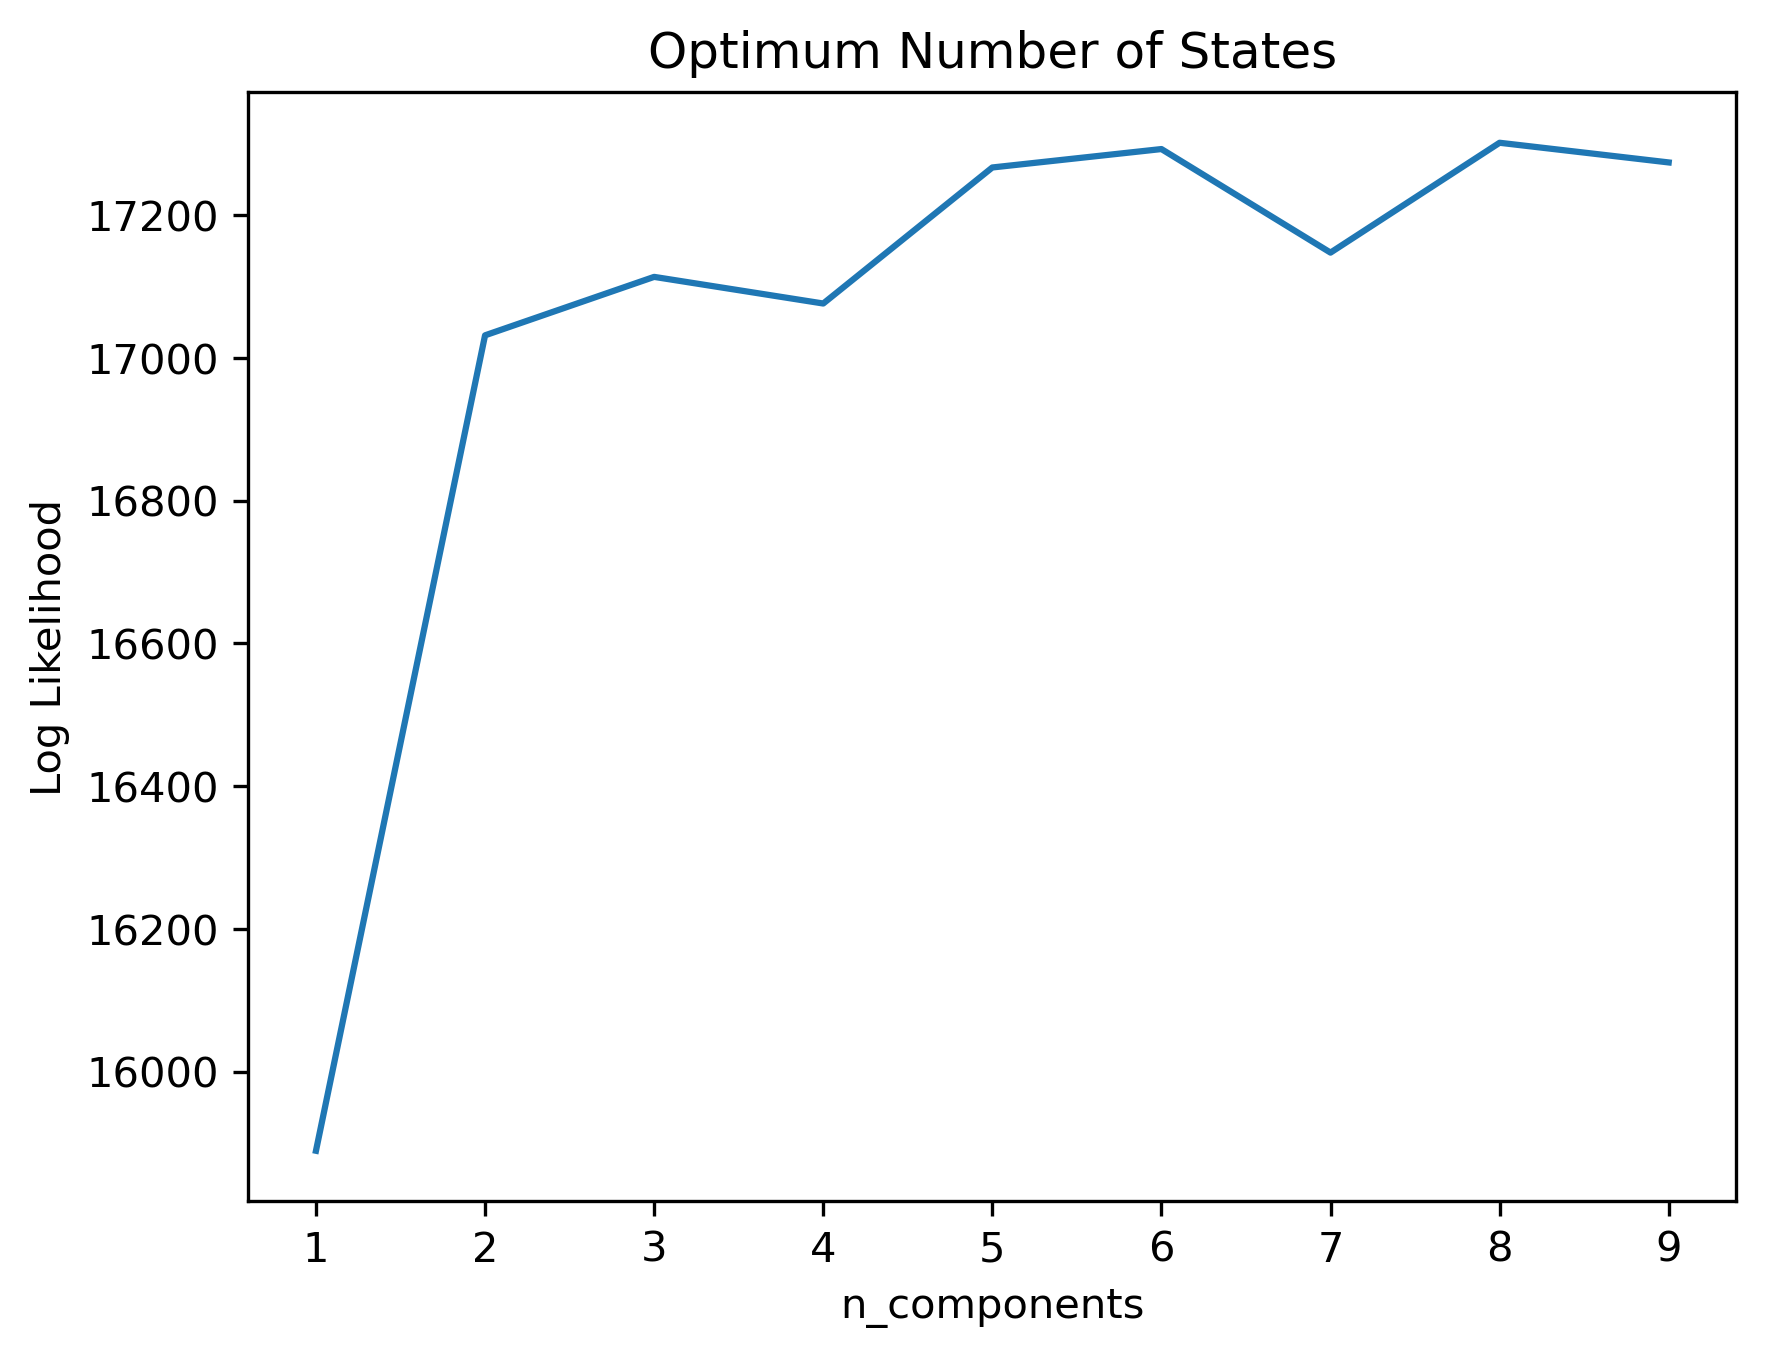

In [131]:
sp_ret = SP['return'].dropna().values.reshape(-1,1)
n_components = np.arange(1, 10)
clusters = [hmm.GaussianHMM(n_components=n, 
                            covariance_type="full").fit(sp_ret)
           for n in n_components]
plt.plot(n_components, [m.score(np.array(SP['return'].dropna())\
                                .reshape(-1,1)) for m in clusters])
plt.title('Optimum Number of States')
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')

In [132]:
hmm_model = hmm.GaussianHMM(n_components=3, 
                        covariance_type="full", 
                        random_state=123).fit(sp_ret)
hidden_states = hmm_model.predict(sp_ret)

In [133]:
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib import cm

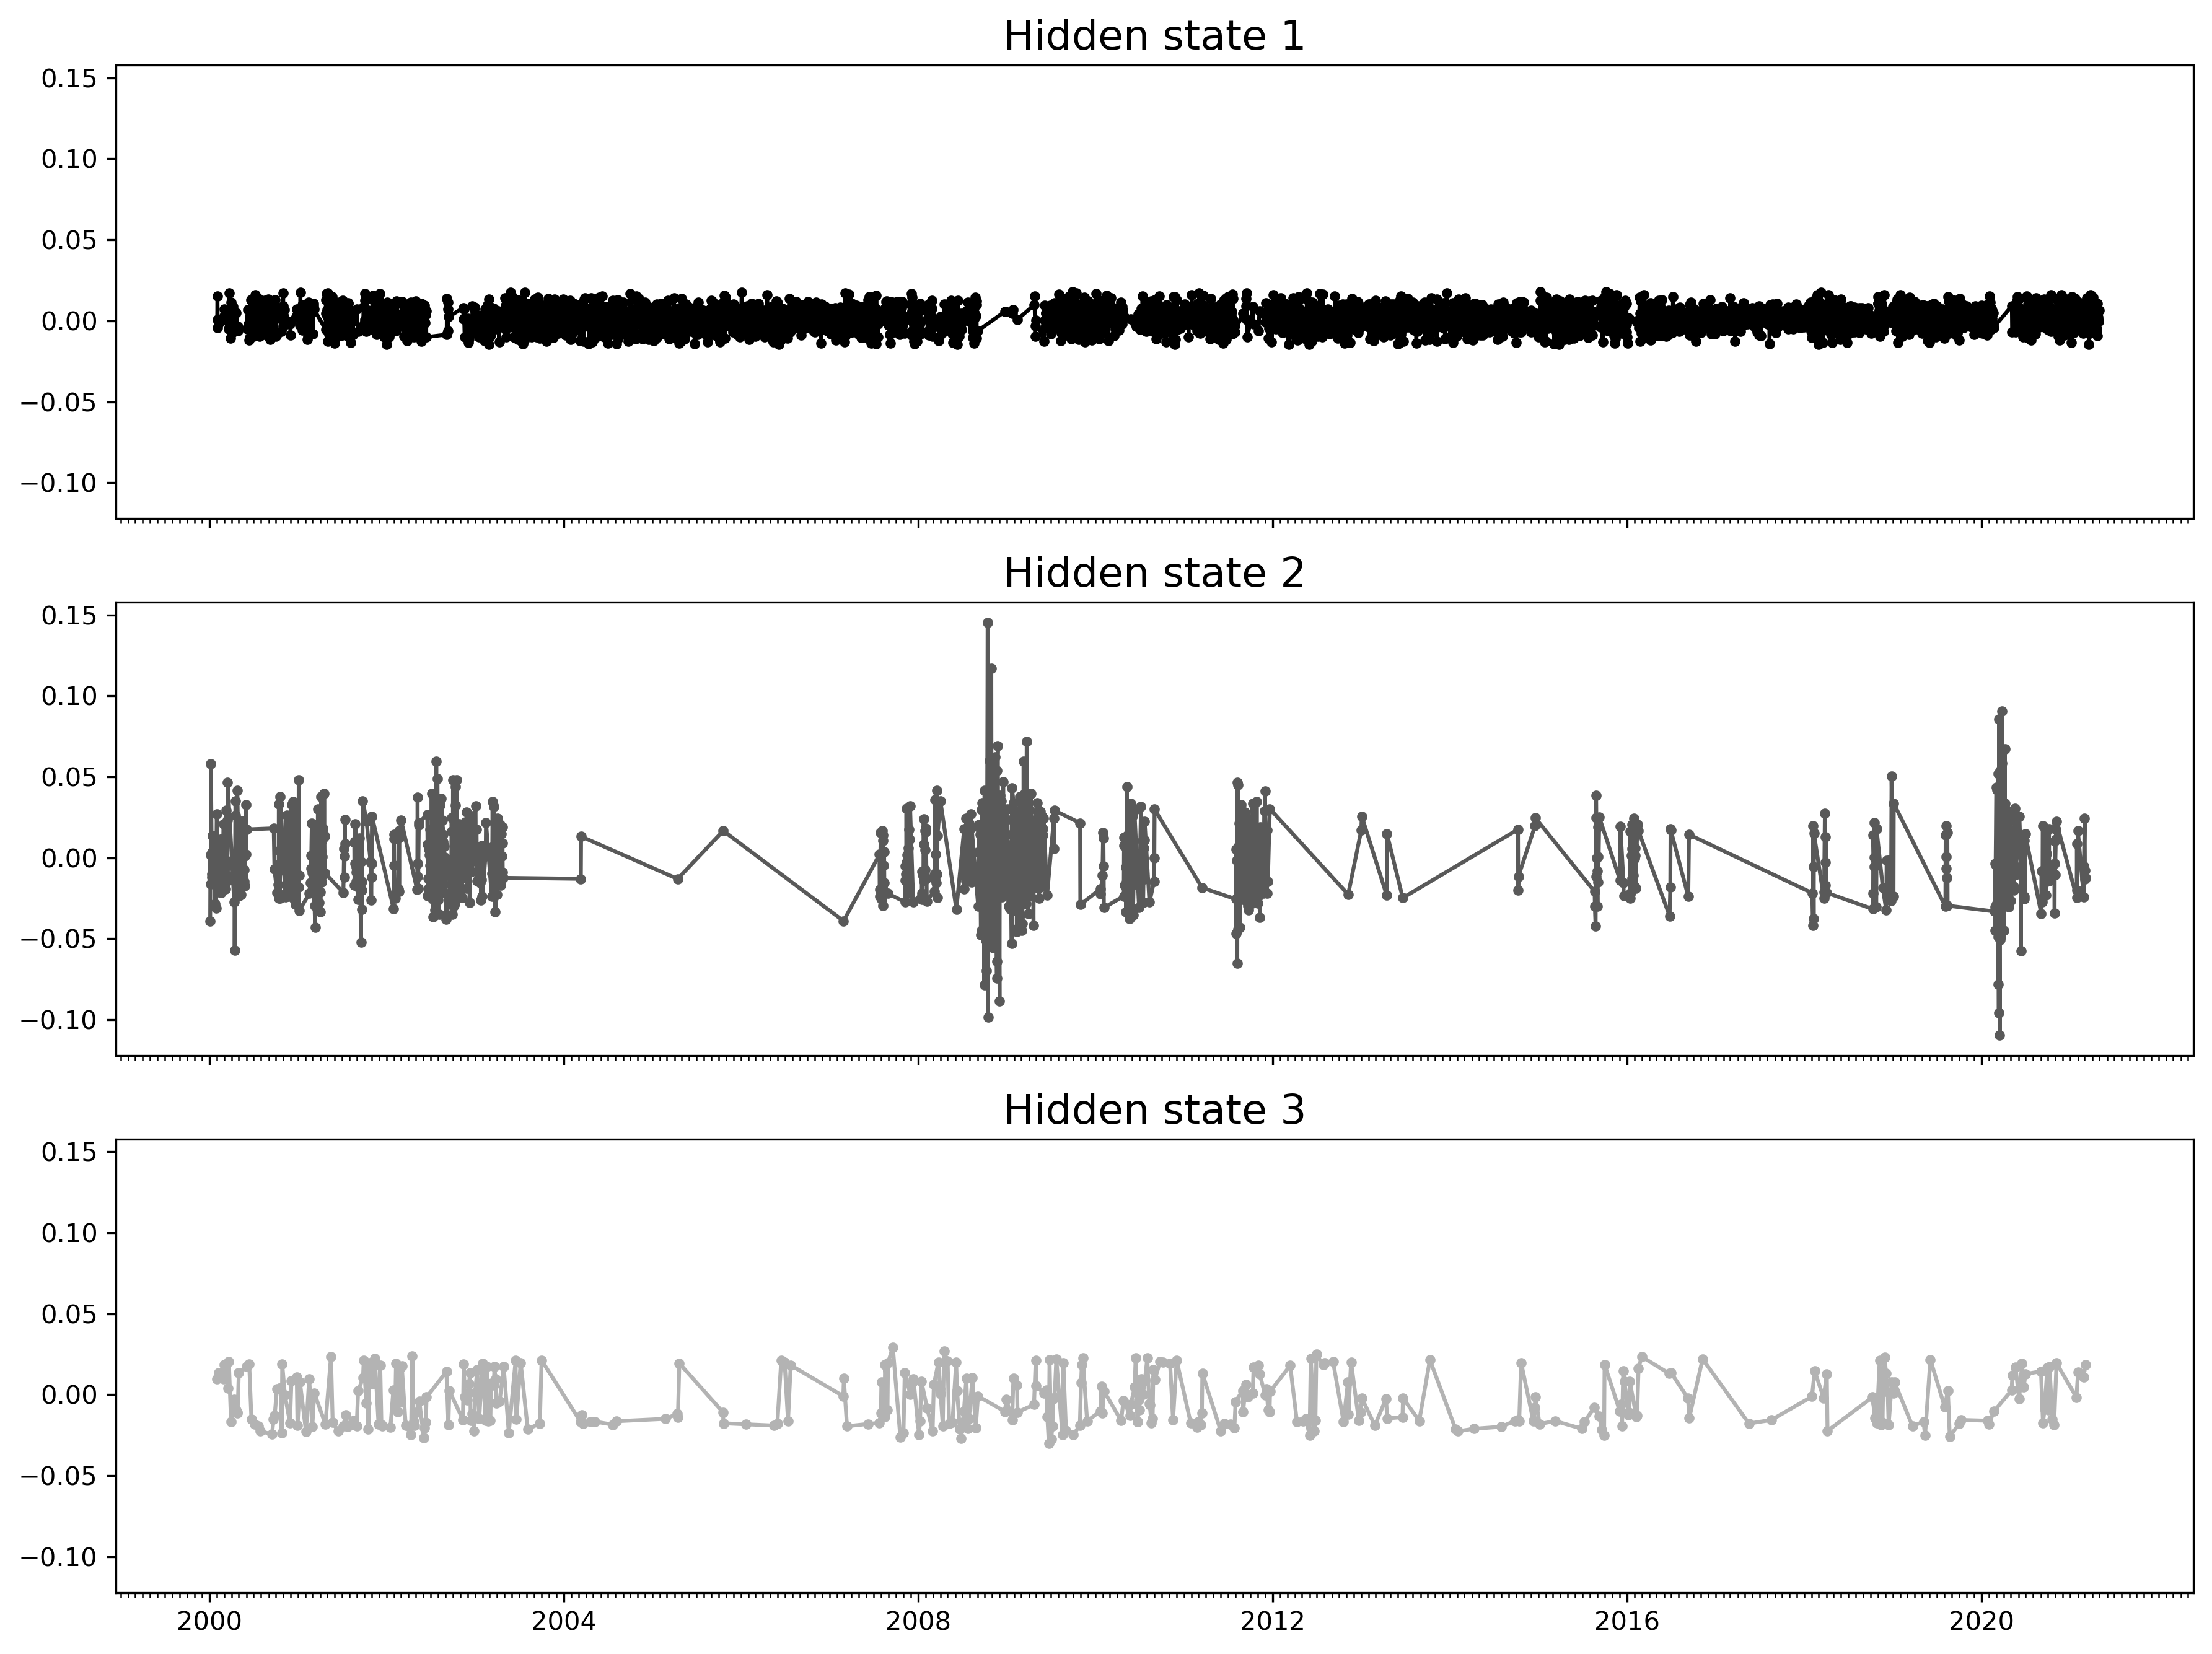

In [134]:
df_sp_ret = SP['return'].dropna()

hmm_model = hmm.GaussianHMM(n_components=3, 
                            covariance_type="full", 
                            random_state=123).fit(sp_ret)

hidden_states = hmm_model.predict(sp_ret)

fig, axs = plt.subplots(hmm_model.n_components, sharex=True,
                        sharey=True, figsize=(12, 9))
colors = cm.gray(np.linspace(0, 0.7, hmm_model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = hidden_states == i
    ax.plot_date(df_sp_ret.index.values[mask],
                 df_sp_ret.values[mask],
                 ".-", c=color)
    ax.set_title("Hidden state {}".format(i + 1), fontsize=16)
    ax.xaxis.set_minor_locator(MonthLocator())
plt.tight_layout()

In [135]:
ret_merged.groupby('states')['return'].mean()

states
0    0.001113
1   -0.006968
2   -0.000912
Name: return, dtype: float64

## Fama-French Model vs. HMM

In [136]:
ff_merge['return'] = ff_merge['Close'].pct_change()
ff_merge.dropna(inplace=True)

In [137]:
split = int(len(ff_merge) * 0.9)
train_ff= ff_merge.iloc[:split].dropna()
test_ff = ff_merge.iloc[split:].dropna()

In [138]:
hmm_model = hmm.GaussianHMM(n_components=3,
                            covariance_type="full",
                            n_iter=100, init_params=" ")

In [139]:
predictions = []

for i in range(len(test_ff)):
    hmm_model.fit(train_ff)
    adjustment = np.dot(hmm_model.transmat_, hmm_model.means_)
    predictions.append(test_ff.iloc[i] + adjustment[0])
predictions = pd.DataFrame(predictions)

Model is not converging.  Current: 6110.251890945218 is not greater than 6110.331585725312. Delta is -0.07969478009363229
Model is not converging.  Current: 6110.065610301925 is not greater than 6110.1560570864. Delta is -0.09044678447571641
Model is not converging.  Current: 6109.91997299493 is not greater than 6109.986614262241. Delta is -0.06664126731175202
Model is not converging.  Current: 6109.819598918208 is not greater than 6109.864785580534. Delta is -0.04518666232615942
Model is not converging.  Current: 6109.753229416859 is not greater than 6109.782886655766. Delta is -0.029657238907020655
Model is not converging.  Current: 6109.710257374048 is not greater than 6109.7293763314465. Delta is -0.019118957398859493
Model is not converging.  Current: 6109.682784673748 is not greater than 6109.694974612663. Delta is -0.012189938915071252
Model is not converging.  Current: 6109.665360026248 is not greater than 6109.673078309408. Delta is -0.007718283160102146
Model is not convergin

In [140]:
std_dev = predictions['return'].std()
sharpe = predictions['return'].mean() / std_dev
print('Sharpe ratio with HMM is {:.4f}'.format(sharpe))

Sharpe ratio with HMM is 0.0847


## Fama-French Model with OLS

In [141]:
import statsmodels.api as sm

In [142]:
Y = train_ff['return']
X = train_ff[['Mkt-RF', 'SMB', 'HML']]

In [143]:
model = sm.OLS(Y, X)
ff_ols = model.fit()
print(ff_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          4.072e+04
Date:                Fri, 31 Jan 2025   Prob (F-statistic):                        0.00
Time:                        19:13:57   Log-Likelihood:                          22347.
No. Observations:                4827   AIC:                                 -4.469e+04
Df Residuals:                    4824   BIC:                                 -4.467e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [144]:
ff_pred = ff_ols.predict(test_ff[["Mkt-RF", "SMB", "HML"]])
ff_pred.head()

Date
2019-03-14   -0.000340
2019-03-15    0.005178
2019-03-18    0.004273
2019-03-19   -0.000194
2019-03-20   -0.003795
dtype: float64

In [145]:
std_dev = ff_pred.std()
sharpe = ff_pred.mean() / std_dev
print('Sharpe ratio with FF 3 factor model is {:.4f}'.format(sharpe))

Sharpe ratio with FF 3 factor model is 0.0589


In [146]:
split = int(len(SP['return']) * 0.9)
train_ret_SP = SP['return'].iloc[split:].dropna()
test_ret_SP = SP['return'].iloc[:split].dropna()

In [147]:
hmm_model = hmm.GaussianHMM(n_components=3,
                            covariance_type="full",
                            n_iter=100)
hmm_model.fit(np.array(train_ret_SP).reshape(-1, 1))
hmm_predict_vol = hmm_model.predict(np.array(test_ret_SP)
                                    .reshape(-1, 1))
pd.DataFrame(hmm_predict_vol).value_counts()

Model is not converging.  Current: 1670.5861770180877 is not greater than 1670.5919189201882. Delta is -0.005741902100453444


2    4420
1     305
0     102
Name: count, dtype: int64

## Synthetic Data Generation and Hidden Markov

In [148]:
startprob = hmm_model.startprob_
transmat = hmm_model.transmat_
means = hmm_model.means_ 
covars = hmm_model.covars_

In [149]:
syn_hmm = hmm.GaussianHMM(n_components=3, covariance_type="full")

In [150]:
syn_hmm.startprob_ = startprob
syn_hmm.transmat_ = transmat 
syn_hmm.means_ = means 
syn_hmm.covars_ = covars

In [151]:
syn_data, _ = syn_hmm.sample(n_samples=1000)

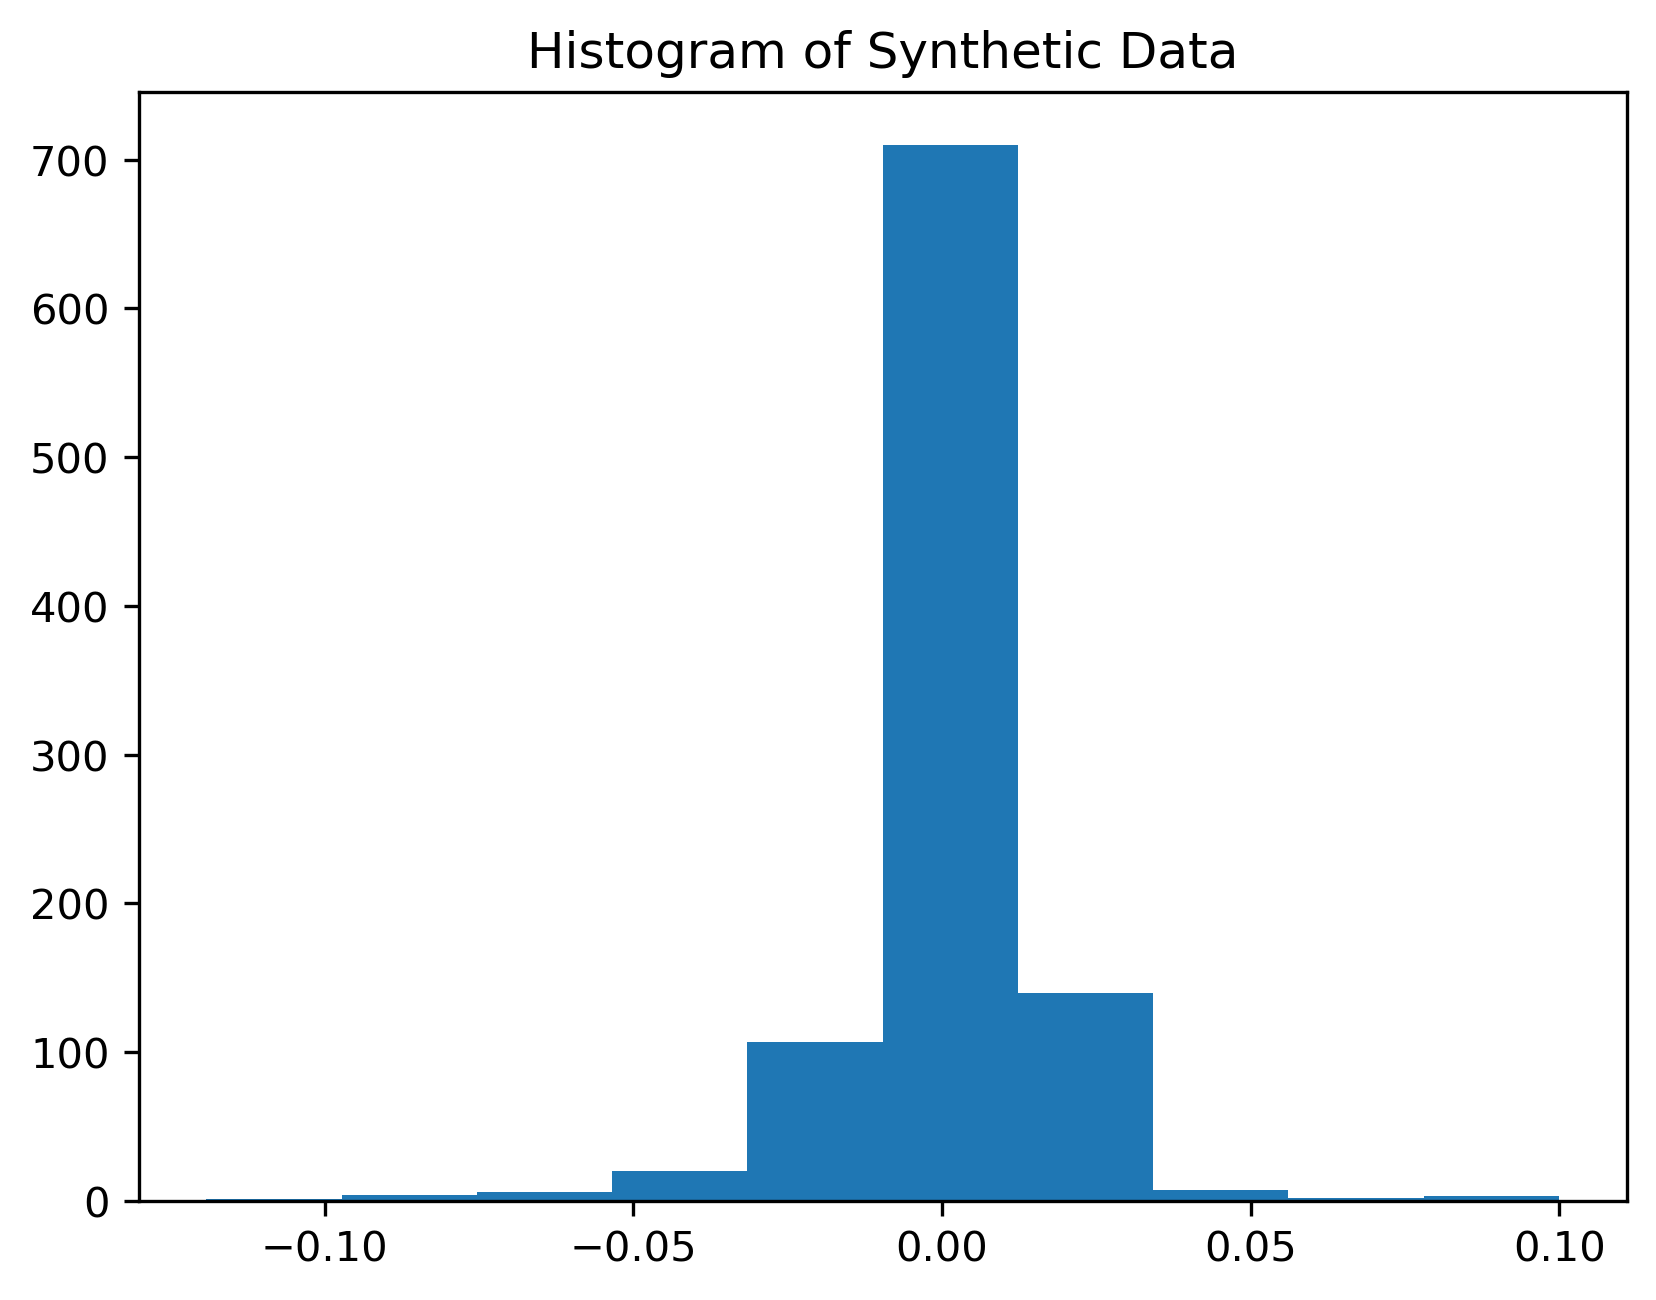

In [152]:
plt.hist(syn_data)
plt.title('Histogram of Synthetic Data')
plt.show()

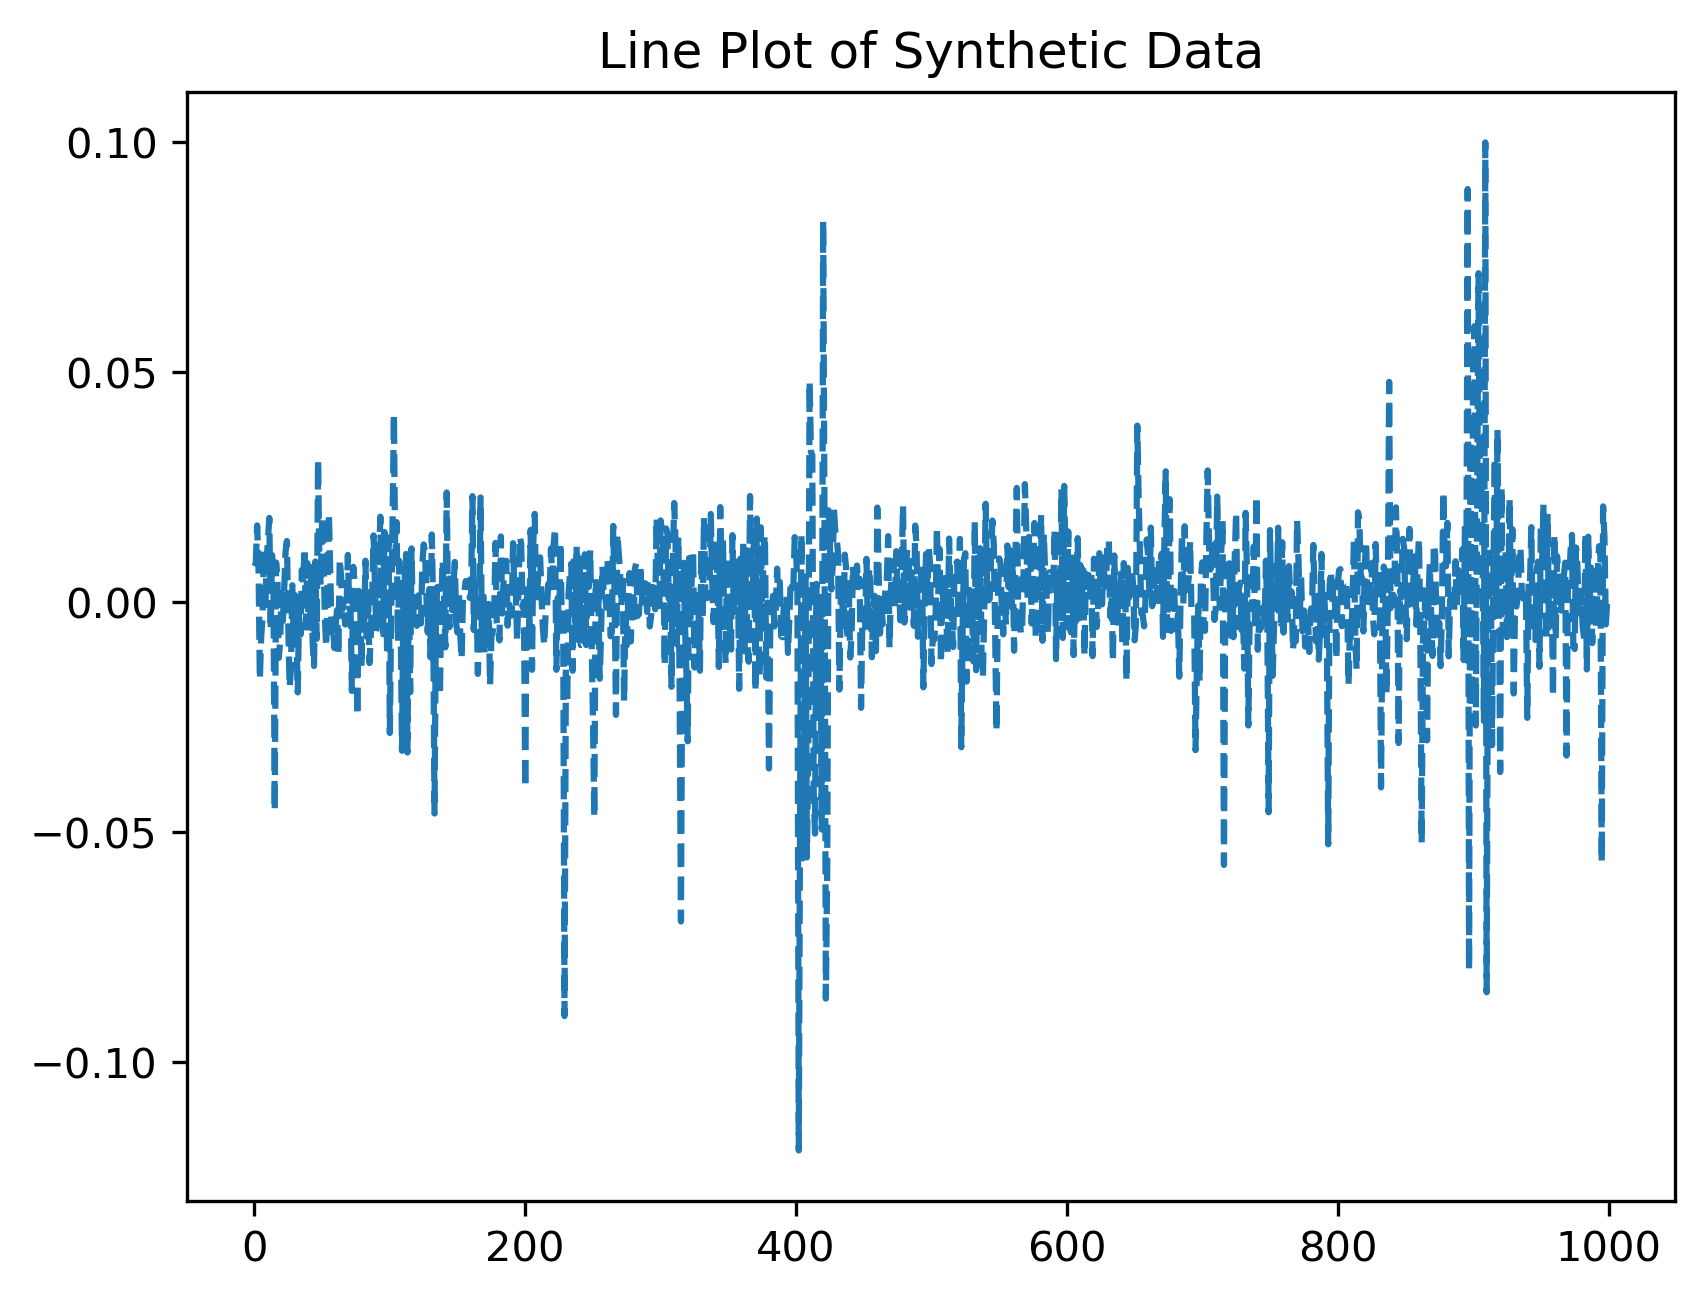

In [153]:
plt.plot(syn_data, "--")
plt.title('Line Plot of Synthetic Data')
plt.show()